In [1]:
#importing libraries

import os
import numpy as np
import torch
import time
import torch.utils.data
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import cv2
import glob
from PIL import Image
import ntpath
import os
from tqdm import tqdm
from tqdm import trange
%matplotlib inline

In [2]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

lr = 0.01 
epochs=20
device = 'cuda'
train_batch_size = 128
test_batch_size = 128
ACLASSES = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

### DATASET CLASS

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.classes = os.listdir(data_folder)
        self.class_to_idx = {'buildings':0,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
        self.samples = self.make_dataset()
        
    def make_dataset(self):
        samples = []
        for target_class in self.classes:
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(self.data_folder, target_class)
            target_files = os.listdir(target_dir)
            for file in target_files:
                path = os.path.join(target_dir, file)
                samples.append((path, class_index))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = Image.open(path)
        
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

### INITIALISE THE DATASET and THE DATALOADERS 

In [4]:

START_seed()
# Define your transformations
train_transform = transforms.Compose([transforms.Resize((224,224)),  transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) #add your augmentations
test_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Train dataset
train_dataset = CustomDataset(data_folder='/l/users/santosh.sanjeev/NIdataset_v2/seg_train', transform=train_transform)
val_dataset = CustomDataset(data_folder='/l/users/santosh.sanjeev/NIdataset_v2/seg_val', transform=test_transform)
test_dataset = CustomDataset(data_folder='/l/users/santosh.sanjeev/NIdataset_v2/seg_test', transform=test_transform)

print(len(train_dataset), len(val_dataset), len(test_dataset))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, num_workers = 8)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=train_batch_size, shuffle=True, num_workers = 8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False, num_workers = 8)

11224 2810 3000


## Visualizing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


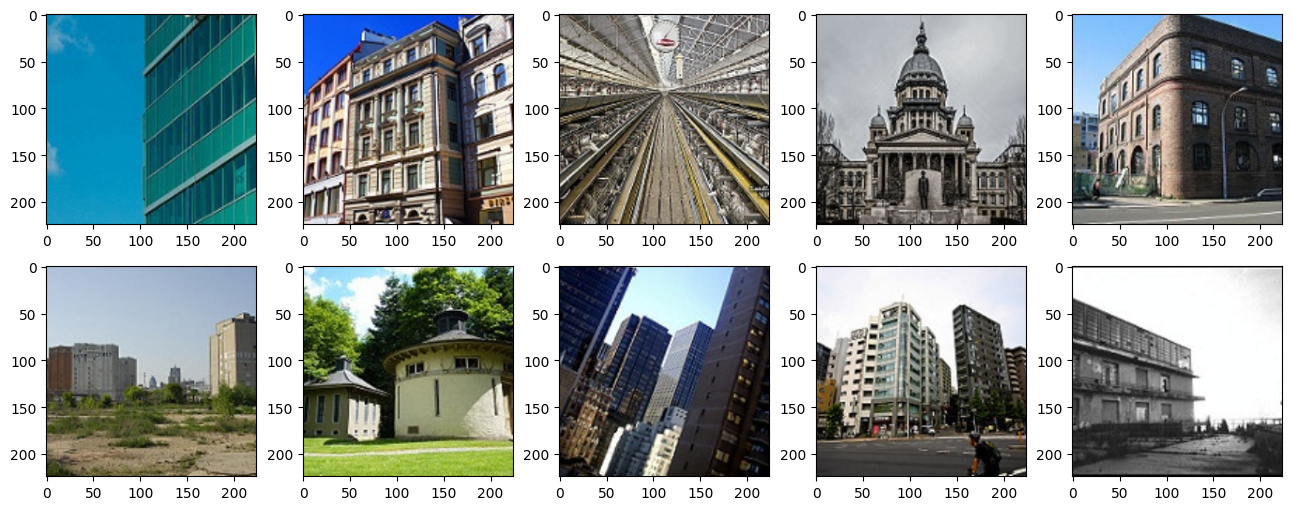

In [5]:
# show some images
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    image= image.permute(1,2,0).numpy()
    image = (image*std)+mean
    plt.imshow(image)

### Training and evaluation loop

In [6]:
# ## Creating training loop
def train(model):
    model.train()
    train_loss = 0
    total = 0
    correct=0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)
    
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        print(' train loss: {:.4f} accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct/total))

In [7]:
best_accuracy = 0.0
def validate(model):
    global best_accuracy
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        if (100.*correct/total) > best_accuracy:
            print("Saving the best model...")
            best_accuracy = (100.*correct/total)
            torch.save(model.state_dict(), 'best_model.pth')
        print(' val loss: {:.4f} accuracy: {:.4f} best_accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total, best_accuracy))


### Initialise the model, optimizers, schedulers 

In [8]:
START_seed()
import torchvision.models as models

# model = models.vgg16(pretrained=False)
# model.classifier[-1].out_features = 6
# model.head = nn.Linear(model.head.in_features, 6)

model = models.resnet18(pretrained=False)
# model.classifier[-1].out_features = 6
model.fc = nn.Linear(model.fc.in_features, 6)

print(model)

pytorch_total_params = sum(p.numel() for p in  model.parameters())
print('Number of parameters: {0}'.format(pytorch_total_params))

/home/sebastian.cavada/.conda/envs/ai701/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sebastian.cavada/.conda/envs/ai701/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr) 


In [11]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [10]:
model.to(device)
start = time.time()

for epoch in range(0, epochs):
    print("epoch number: {0}".format(epoch))
    train( model)
    validate(model)
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

epoch number: 0


  0%|          | 0/88 [00:00<?, ?batch/s]/home/sebastian.cavada/.conda/envs/ai701/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 88/88 [00:23<00:00,  3.70batch/s]


 train loss: 163.1948 accuracy: 50.6949


100%|██████████| 22/22 [00:05<00:00,  4.32batch/s]


Saving the best model...
 val loss: 1.0438 accuracy: 63.3452 best_accuracy: 63.3452
epoch number: 1


100%|██████████| 88/88 [00:21<00:00,  4.02batch/s]


 train loss: 116.6728 accuracy: 65.8767


100%|██████████| 22/22 [00:04<00:00,  5.26batch/s]


Saving the best model...
 val loss: 0.9050 accuracy: 67.1530 best_accuracy: 67.1530
epoch number: 2


100%|██████████| 88/88 [00:22<00:00,  3.89batch/s]


 train loss: 96.0329 accuracy: 73.0221


100%|██████████| 22/22 [00:03<00:00,  5.58batch/s]


Saving the best model...
 val loss: 0.8068 accuracy: 69.3950 best_accuracy: 69.3950
epoch number: 3


100%|██████████| 88/88 [00:22<00:00,  3.98batch/s]


 train loss: 84.1510 accuracy: 76.5324


100%|██████████| 22/22 [00:03<00:00,  5.79batch/s]


 val loss: 1.2128 accuracy: 57.2598 best_accuracy: 69.3950
epoch number: 4


100%|██████████| 88/88 [00:21<00:00,  4.03batch/s]


 train loss: 75.3805 accuracy: 78.5816


100%|██████████| 22/22 [00:03<00:00,  5.66batch/s]


 val loss: 1.0696 accuracy: 63.3452 best_accuracy: 69.3950
epoch number: 5


100%|██████████| 88/88 [00:22<00:00,  3.96batch/s]


 train loss: 70.6620 accuracy: 79.9091


100%|██████████| 22/22 [00:05<00:00,  4.33batch/s]


Saving the best model...
 val loss: 0.5673 accuracy: 79.6441 best_accuracy: 79.6441
epoch number: 6


100%|██████████| 88/88 [00:29<00:00,  3.02batch/s]


 train loss: 64.6577 accuracy: 81.6376


100%|██████████| 22/22 [00:05<00:00,  3.77batch/s]


 val loss: 0.6110 accuracy: 77.4377 best_accuracy: 79.6441
epoch number: 7


100%|██████████| 88/88 [00:30<00:00,  2.92batch/s]


 train loss: 59.7894 accuracy: 83.3660


100%|██████████| 22/22 [00:05<00:00,  3.80batch/s]


 val loss: 0.7681 accuracy: 73.7011 best_accuracy: 79.6441
epoch number: 8


100%|██████████| 88/88 [00:27<00:00,  3.17batch/s]


 train loss: 56.8506 accuracy: 83.7758


100%|██████████| 22/22 [00:04<00:00,  5.22batch/s]


Saving the best model...
 val loss: 0.5197 accuracy: 82.3132 best_accuracy: 82.3132
epoch number: 9


100%|██████████| 88/88 [00:27<00:00,  3.18batch/s]


 train loss: 54.9967 accuracy: 84.6579


100%|██████████| 22/22 [00:04<00:00,  4.97batch/s]


 val loss: 0.5637 accuracy: 80.1779 best_accuracy: 82.3132
epoch number: 10


100%|██████████| 88/88 [00:28<00:00,  3.06batch/s]


 train loss: 51.9461 accuracy: 85.5845


100%|██████████| 22/22 [00:06<00:00,  3.58batch/s]


Saving the best model...
 val loss: 0.5000 accuracy: 82.5267 best_accuracy: 82.5267
epoch number: 11


100%|██████████| 88/88 [00:29<00:00,  2.96batch/s]


 train loss: 48.8659 accuracy: 86.4220


100%|██████████| 22/22 [00:06<00:00,  3.59batch/s]


 val loss: 0.5402 accuracy: 81.2811 best_accuracy: 82.5267
epoch number: 12


100%|██████████| 88/88 [00:29<00:00,  2.94batch/s]


 train loss: 45.6637 accuracy: 87.4644


100%|██████████| 22/22 [00:05<00:00,  3.87batch/s]


 val loss: 0.5640 accuracy: 79.8932 best_accuracy: 82.5267
epoch number: 13


100%|██████████| 88/88 [00:31<00:00,  2.78batch/s]


 train loss: 43.7775 accuracy: 87.6158


100%|██████████| 22/22 [00:04<00:00,  4.64batch/s]


 val loss: 0.8070 accuracy: 75.0178 best_accuracy: 82.5267
epoch number: 14


 65%|██████▍   | 57/88 [00:22<00:11,  2.59batch/s]


KeyboardInterrupt: 

### Test the model 

In [27]:
def test_best_model(model, test_loader, criterion, best_model_path):
    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print('Test loss: {:.4f} Accuracy: {:.2f}%'.format(test_loss/(batch_idx+1), accuracy))

# Usage example:

# Assuming you have a model, test_loader, and best_model_path defined

best_model_path = 'best_model.pth'  # Replace with the actual path and filename of the best model

test_best_model(model, test_loader, nn.CrossEntropyLoss(), best_model_path)


100%|████████████████████████████████████████| 24/24 [00:12<00:00,  1.89batch/s]

Test loss: 2.0488 Accuracy: 17.50%
